In [1]:
import os.path as path
import glob, os
from datetime import datetime
from importlib.metadata import version
import cobra
import thermo_flux
from thermo_flux.io import load_excel as ex
from thermo_flux.io import helper_load as hl
from thermo_flux.core.model import ThermoModel
from thermo_flux.solver.gurobi import variability_analysis, variability_results, compute_IIS
from equilibrator_api import  Q_
import pandas as pd
import numpy as np
from scripts.logger import write_to_log
import gurobipy as gp
from gurobipy import GRB
from scripts.gen_model import gen_model
from scripts.gen_model import apply_physio_data
from scripts.gen_model import constrain_bounds_fva
from scripts.reaction_utils import list_and_remove_blocked_reactions
from scripts.reaction_utils import list_blocked_reactions
from scripts.reaction_utils import count_blocked_pathways
from scripts.reaction_utils import tfva_write_scenarios
import enkie
import pta
import importlib
from scripts.metabolite_utils import remove_orphan_metabolites

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [2]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "regression/reed.csv"
INPUT_INCHI = "regression/InChIs.csv"
INPUT_GAMS = "regression/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "regression/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "regression/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "regression/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"

OUTPUT_DIR = "output"
OUTPUT_NAME = f"pta_test"
OUTPUT_LOG = f"{OUTPUT_DIR}{path.sep}{OUTPUT_NAME}_log.txt"

CONDITIONS_TO_REGRESS = ["WT-Glc_I"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = False
RELAX_EXP_FLUX_BOUNDS = 2.0

time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
write_to_log(OUTPUT_LOG, f"Started analysis at: {time}", "w")

# Write package versions:
modules = ["pandas", "numpy", "equilibrator_api", "cobra"]
write_to_log(OUTPUT_LOG, f"Package versions used:")
versions_packages = [f"  {m}: {version(m)}\n" for m in modules]
write_to_log(OUTPUT_LOG, "".join(versions_packages))

In [ ]:
import os
print(os.environ.get('GUROBI_HOME'))
print(os.environ.get('LD_LIBRARY_PATH'))


In [ ]:
model = pta.load_example_model("e_coli_core")
model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.5

In [3]:
tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
tmodel = apply_physio_data(tmodel, CONDITIONS_TO_REGRESS[0], INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, False, OUTPUT_LOG)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Read parameters from file gurobi.env
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' cre

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [4]:
print(tmodel.metabolites.cdpdag1_c.annotation) # Doesnt exist in KEGG

{'kegg': 'C95007', 'bigg.metabolite': 'cdpdag1'}


In [4]:
blocked_p = list_blocked_reactions(tmodel, CONDITIONS_TO_REGRESS[0], OUTPUT_LOG, 1, False)
print(len(blocked_p))

tmodel.remove_reactions(blocked_p, remove_orphans=True)
remove_orphan_metabolites(tmodel)
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
tmodel.update_thermo_info(fit_unknown_dfG0=True)

['3HCINNMH', '3HPPPNH', '4HTHRS', '5DGLCNR', 'AADDGT', 'AB6PGH', 'ACACCT', 'ACACT1r', 'ACBIPGT', 'ACGAMT', 'ACMAMUT', 'ACNML', 'ACONMT', 'ACPS1', 'ADHEr', 'ADK4', 'ADNCYC', 'ADOCBIK', 'ADOCBLS', 'AGDC', 'AGMT', 'AHC', 'AHCYSNS', 'ALCD19', 'ALDD19x', 'ALLTAH', 'alltn', 'ALTRH', 'AMANAPE', 'AMANK', 'AMAOTr', 'AMMQT82', 'AMPMS', 'AOXSr', 'AP4AH', 'AP5AH', 'ARAI', 'ARGDC', 'BTS2', 'BUTCT', 'CBIAT', 'CBLAT', 'CDPMEK', 'CHRPL', 'CINNDO', 'CPPPGO', 'CRNBTCT', 'CRNCBCT', 'CRNCDH', 'CYANST', 'CYNTAH', 'DBTSr', 'DDGALK', 'DDGLK', 'DDPGALA', 'DHBD', 'DHBSr', 'DHCIND', 'DHCINDO', 'DHNAOT', 'DHPPD', 'DHPTDC', 'DMATT', 'DMQMT', 'DOGULNR', 'DXPRIi', 'DXPS', 'DXYLK', 'E4PD', 'ECAPEC', 'EDTXS3', 'EDTXS4', 'ENTCS', 'FAO3', 'FAO4', 'FCI', 'FCLK', 'FCLPA', 'FCLT', 'FFSD', 'FHL', 'G1PTT', 'G1SATi', 'GALCTD', 'GALCTND', 'GALKr', 'GALS3', 'GDMANE', 'GLCRAL', 'GLCRD', 'GLTPD', 'glucys', 'GLUTRR', 'GLUTRS', 'GMAND', 'GOFUCR', 'GP4GH', 'GPDDA1', 'GPDDA3', 'GPDDA5', 'GRTT', 'GTHOr', 'GTHS', 'GUI1', 'GUI2', 'HBZO

In [54]:
for r in tmodel.reactions:
    if(r.upper_bound <-9):
        print(r.id)
        print(r.lower_bound)
        print(r.upper_bound)

EX_glc
-12.148855548767477
-9.302806592838524
EX_o2
-25.64184695305984
-9.117049900823162


In [5]:
import cobra.io
from scripts.io import export_tmodel_cobra
from scripts.io import load_tmodel_cobra
from scripts.metabolite_utils import remove_orphan_metabolites

output_path = export_tmodel_cobra(tmodel, "models/pta_test.json")
cobra_model = load_tmodel_cobra(output_path, strip_compartment=True, metabolite_namespace= "bigg.metabolite")

#remove_orphan_metabolites(cobra_model)
pta.prepare_for_pta(cobra_model, biomass_id="biomass_EX", atpm_id="ATPHYD", remove_blocked_reactions=False, tighten_bounds=False, prevent_loops=False, autoresolve_inconsistencies=False)

[{'id': '2dhglcn_c', 'name': '2dhglcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H8'}, {'id': 'nadh_c', 'name': 'nadh_c', 'compartment': 'c', 'charge': -2, 'formula': 'H27'}, {'id': 'glcn_c', 'name': 'glcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'nad_c', 'name': 'nad_c', 'compartment': 'c', 'charge': -1, 'formula': 'H26'}, {'id': 'nadph_c', 'name': 'nadph_c', 'compartment': 'c', 'charge': -4, 'formula': 'H26'}, {'id': 'nadp_c', 'name': 'nadp_c', 'compartment': 'c', 'charge': -3, 'formula': 'H25'}, {'id': '2dhguln_c', 'name': '2dhguln_c', 'compartment': 'c', 'charge': -1, 'formula': 'H9'}, {'id': 'idon-L_c', 'name': 'idon-L_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'o2_c', 'name': 'o2_c', 'compartment': 'c', 'charge': 0, 'formula': 'H0'}, {'id': 'h2o_c', 'name': 'h2o_c', 'compartment': 'c', 'charge': 0, 'formula': 'H2'}, {'id': 'pi_c', 'name': 'pi_c', 'compartment': 'c', 'charge': -2, 'formula': 'H1'}, {'id': '5dglcn_c', 'name': '5dgl

In [ ]:
from pta import StructuralAssessment
from scripts.reaction_utils import fix_negative_upper_bounds

temp_model = cobra_model.copy()
fix_negative_upper_bounds(temp_model)
assessment = StructuralAssessment(temp_model, "biomass_EX", "ATPHYD")

Read LP format model from file /tmp/tmpr4a2nuix.lp
Reading time = 0.00 seconds
: 454 rows, 1246 columns, 6358 nonzeros

Starting check for boundary reactions with negative upper bounds...
  - Found boundary reaction 'EX_glc' with UB: -9.3028. Fixing...
  - Found boundary reaction 'EX_o2' with UB: -9.1170. Fixing...
Completed boundary fix. Total reactions temporarily modified: 2
Note: The model's original bounds are restored after the block.
Read LP format model from file /tmp/tmpeczj2bga.lp
Reading time = 0.00 seconds
: 454 rows, 1246 columns, 6358 nonzeros
2025-11-26  16:21:03.248  main                     INFO     | logger initialized
2025-11-26  16:21:03.249  main                     INFO     | =====================================================
2025-11-26  16:21:03.250  main                     INFO     | efmtool version 4.7.1, 2009-12-04 18:30:05
2025-11-26  16:21:03.250  main                     INFO     | Copyright (c) 2009, Marco Terzer, Zurich, Switzerland
2025-11-26  16:21:

In [34]:
atp_rxns = [x for x in cobra_model.reactions if "ATP" in x.id]
print(atp_rxns)
print(cobra_model.reactions.ATPHYD)

bio_rxns = [x for x in cobra_model.reactions if "biomass" in x.id]
print(bio_rxns)
for b in bio_rxns:
    print(b)

[<Reaction ATPHYD at 0x755984804b50>, <Reaction ATPPRT at 0x755984805210>, <Reaction PRATPP at 0x7559615a5dd0>, <Reaction ATPS4r at 0x7559615cbb90>]
ATPHYD: atp_c + h2o_c --> adp_c + h_c + pi_c
[<Reaction biomass at 0x7559615e1450>, <Reaction biomass_ce at 0x7559867356d0>, <Reaction biomass_EX at 0x755986735a10>]
biomass: 0.05 5mthf_c + 5e-05 accoa_c + 0.488 ala-L_c + 0.001 amp_c + 0.281 arg-L_c + 0.229 asn-L_c + 0.229 asp-L_c + 54.1352 atp_c + 0.000129 clpnEC_c + 6e-06 coa_c + 0.126 ctp_c + 0.087 cys-L_c + 0.0247 datp_c + 0.0254 dctp_c + 0.0254 dgtp_c + 0.0247 dttp_c + 1e-05 fad_c + 0.25 gln-L_c + 0.25 glu-L_c + 0.582 gly_c + 0.154 glycogen_c + 0.203 gtp_c + 53.95 h2o_c + 0.09 his-L_c + 0.276 ile-L_c + 0.428 leu-L_c + 0.0084 lpsEC_c + 0.326 lys-L_c + 0.146 met-L_c + 0.00215 nad_c + 5e-05 nadh_c + 0.00013 nadp_c + 0.0004 nadph_c + 0.001935 peEC_c + 0.0276 peptidoEC_c + 0.000464 pgEC_c + 0.176 phe-L_c + 0.21 pro-L_c + 5.2e-05 psEC_c + 0.035 ptrc_c + 0.205 ser-L_c + 0.007 spmd_c + 3e-06 

In [7]:
print([x.annotation for x in cobra_model.metabolites])

[{'bigg.metabolite': '2dhglcn'}, {'bigg.metabolite': 'nadh'}, {'bigg.metabolite': 'glcn'}, {'bigg.metabolite': 'nad'}, {'bigg.metabolite': 'nadph'}, {'bigg.metabolite': 'nadp'}, {'bigg.metabolite': '2dhguln'}, {'bigg.metabolite': 'idon__L'}, {'bigg.metabolite': 'o2'}, {'bigg.metabolite': 'h2o'}, {'bigg.metabolite': 'pi'}, {'bigg.metabolite': '5dglcn'}, {'bigg.metabolite': 'ru5p__D'}, {'bigg.metabolite': 'ara5p'}, {'bigg.metabolite': 'ACP'}, {'bigg.metabolite': 'atp'}, {'bigg.metabolite': 'ttdca'}, {'bigg.metabolite': 'amp'}, {'bigg.metabolite': 'myrsACP'}, {'bigg.metabolite': 'ppi'}, {'bigg.metabolite': 'ttdcea'}, {'bigg.metabolite': 'tdeACP'}, {'bigg.metabolite': 'hdca'}, {'bigg.metabolite': 'palmACP'}, {'bigg.metabolite': 'hdcea'}, {'bigg.metabolite': 'hdeACP'}, {'bigg.metabolite': 'ocdcea'}, {'bigg.metabolite': 'octeACP'}, {'bigg.metabolite': 'dtdp'}, {'bigg.metabolite': 'g6p'}, {'bigg.metabolite': '4abut'}, {'bigg.metabolite': 'akg'}, {'bigg.metabolite': 'glu__L'}, {'bigg.metabolit

In [6]:
from scripts.reaction_utils import pta_get_concentrations

In [7]:
from scripts.reaction_utils import pta_get_parameters

In [10]:
solution = cobra_model.optimize()
print(solution.status)

optimal


In [ ]:
print(tmodel.dfG0_cov_sqrt) # Cov sqrt
print(tmodel.dfG0_cov_sqrt @ tmodel.dfG0_cov_sqrt.T) # Cov sqrt -> transpose of itself -> cov

[[-1.7586239756117727e-11 -1.662038562333379e-11 1.505729915751708e-11  ... 0.0 0.0 0.0] [-5.8832850990064856e-05 -7.349299085701588e-05 -0.00011212457465070713  ... 0.0 0.0 0.0] [-6.769199196234467e-12 -2.5209677959575962e-11 -5.514393541415204e-12  ... 0.0 0.0 0.0] ... [5.674148650935962e-12 2.7423445458918394e-11 9.560211997050594e-12 ...  0.0 0.0 0.0] [-2.5683144189061916e-19 -4.803820997523787e-20 -1.0249253325451681e-19  ... 0.0 0.0 0.0] [-2.5683144189061916e-19 -4.803820997523787e-20 -1.0249253325451681e-19  ... 0.0 0.0 0.0]] kilojoule / mole
[[9.730538760001465 -0.1316170992384827 8.595866115721517 ...  0.7817914140693223 -6.627018618993136e-16 -6.627018618993152e-16] [-0.1316170992384827 44.85302506935379 -5.204529297901364e-15 ...  -0.35921947284772393 -8.842793785832313e-15 -8.842793785832313e-15] [8.595866115721517 -5.204529297901364e-15 8.595866115721485 ...  2.3953061756287752e-14 -8.570898621607296e-16 -8.57089862160731e-16] ... [0.7817914140693223 -0.35921947284772393 2

In [13]:
from thermo_flux.tools.drg_tools import calc_model_drG0prime
from enkie import Q

drG0_prime_mean = calc_model_drG0prime(tmodel) 
drG0_prime_mean_cov_sqrt = tmodel._drG0_cov_sqrt
drG0_prime_mean_cov = tmodel._drG0_cov_sqrt @ tmodel._drG0_cov_sqrt.T

drG0_prime_mean = Q(drG0_prime_mean, "kJ/mol")
drG0_prime_mean_cov_sqrt = Q(tmodel._drG0_cov_sqrt, "kJ/mol")
drG0_prime_mean_cov = Q(tmodel._drG0_cov_sqrt @ tmodel._drG0_cov_sqrt.T, "(kJ/mol)^2")

In [14]:
print(drG0_prime_mean)
print(drG0_prime_mean_cov_sqrt)
print(drG0_prime_mean_cov)

[-12.039546384219648 -11.923221085459204 -10.180843698230092 -10.064518399469762 -2.439325118493116 913.2919456744114 856.8567442198314 958.8950087937465 881.1643516372051 926.3111542998165 6.459415746261357 -58.11961823173954 -23.141456439975173 -11.622931874866026 12.255819775913778 24.32144913615207 -28.16627880855964 -26.383343164485268 13.759529372706993 -35.10806703949868 862.013845081927 -7.354026994827649 6.536792976841525 -3.3301592154225546 -10.360871728387565 -18.16065719113658 -93.04069681543152 -18.43144718812897 -19.744472036344177 0.2878584620257243 3.1140137535221584 -28.292355789101066 -17.712992455099425 -22.79237857031876 -20.408599738166345 15.842740368639966 23.51254823250713 -4.91271468788409 0.0 1.4573263986676466 11.807911689135835 -64.68204753751434 -30.848496220345396 -30.375828140312365 -0.040967133278968504 1.7888402260615521 0.1907504877641486 1.7478730927825836 -60.622389425960534 -1.2979116924459504 0.355555903965751 -1.2978413990197168 -1.297859506368922

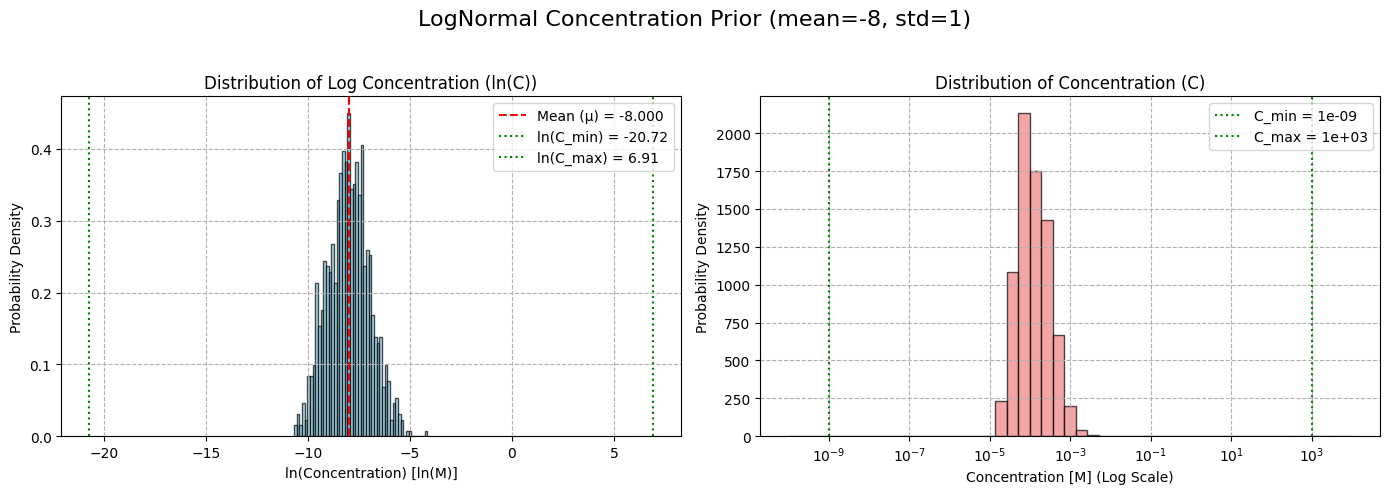

In [ ]:
from scripts.metabolite_utils import graph_ln_dist
# Graph default PTA concentration distribution (1000 samples)
graph_ln_dist(-8, 1)

In [10]:
from scripts.pta_extension import needed_metabolites

nm = needed_metabolites(cobra_model, "bigg.metabolite")
print(nm)

['2DGLCNRx', '2DGLCNRy', '2DGULRx', '2DGULRy', 'A5PISO', 'AACPS1', 'AACPS2', 'AACPS3', 'AACPS4', 'AACPS5', 'ABTA', 'ABUTD', 'ACALDi', 'ACCOACr', 'ACCOAL', 'ACGK', 'ACGS', 'ACHBS', 'ACKr', 'ACLS', 'ACOATA', 'ACODA', 'ACONT', 'ACOTA', 'ACS', 'ADA', 'ADCL', 'ADCS', 'ADD', 'ADK1', 'ADK3', 'ADMDCr', 'ADNK1', 'ADPT', 'ADSK', 'ADSL1r', 'ADSL2r', 'ADSS', 'AGMHE', 'AGPR', 'AICART', 'AIRC2', 'AIRC3', 'ALAALAr', 'ALAR', 'ALATAD2', 'ALATAL', 'ALATAL2', 'ALDD2x', 'AMALT1', 'AMALT2', 'AMALT3', 'AMALT4', 'AMPN', 'ANPRT', 'ANS', 'APRAUR', 'ARGSL', 'ARGSS', 'ASAD', 'ASNN', 'ASNS1', 'ASNS2', 'ASP1DC', 'ASPCT', 'ASPK', 'ASPO3', 'ASPO4', 'ASPO5', 'ASPO6', 'ASPT', 'ASPTA', 'AST', 'ATPHYD', 'ATPPRT', 'BETALDHx', 'BETALDHy', 'BPNT', 'BSORx', 'BSORy', 'C120SN', 'C140SN', 'C141SN', 'C160SN', 'C161SN', 'C181SN', 'CAT', 'CBMK', 'CBPS', 'CDAPPAEC', 'CHORM', 'CHORS', 'CITL', 'CLPNSEC', 'CMPN', 'CS', 'CSND', 'CTPS2', 'CYSS', 'CYSTL', 'cytd', 'CYTDK2', 'CYTK1', 'CYTK2', 'DAAD', 'DADA', 'DADK', 'DAGKEC', 'DAPDC', 'DA

In [12]:
law_ignored = [x.id for x in tmodel.reactions if x.ignore_snd is True]
print(law_ignored)
print(len(law_ignored))

['biomass', 'EX_ac', 'EX_co2', 'EX_glc', 'EX_h', 'EX_h2o', 'EX_nh3', 'EX_o2', 'EX_pi', 'EX_so4', 'H2Ot', 'biomass_ce', 'biomass_EX', 'EX_oro']
14


In [14]:
print(len(nm))
print([x.id for x in tmodel.metabolites if x.id not in nm])
print(tmodel.metabolites.biomass_c.dfG0prime)
print(tmodel.metabolites.biomass_e.dfG0prime)

452
['acgam_c', 'galt_c', 'gam_c', 'man_c', 'mnl_c', 'sbt-D_c', 'sucr_c', 'biomass_c', 'biomass_e', 'Mg_c', 'Mg_e']
709.01190797458 kilojoule / mole
445.5174603856917 kilojoule / mole


In [5]:
from scripts.pta_extension import needed_metabolites

In [13]:
constraints = needed_metabolites(cobra_model, "")
print(constraints[0])
print(len(constraints[0]))

current = set([x.id for x in cobra_model.reactions])
to_keep = set(constraints[0])

final_set = current - to_keep
print(final_set)
print(len(final_set))

tmodel.remove_reactions(list(final_set), remove_orphans=True)
remove_orphan_metabolites(tmodel)
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
tmodel.update_thermo_info(fit_unknown_dfG0=True)




['2DGLCNRx', '2DGLCNRy', '2DGULRx', '2DGULRy', 'A5PISO', 'AACPS1', 'AACPS2', 'AACPS3', 'AACPS4', 'AACPS5', 'ABTA', 'ABUTD', 'ACALDi', 'ACCOACr', 'ACCOAL', 'ACGK', 'ACGS', 'ACHBS', 'ACKr', 'ACLS', 'ACOATA', 'ACODA', 'ACONT', 'ACOTA', 'ACS', 'ADA', 'ADCL', 'ADCS', 'ADD', 'ADK1', 'ADK3', 'ADMDCr', 'ADNK1', 'ADPT', 'ADSK', 'ADSL1r', 'ADSL2r', 'ADSS', 'AGMHE', 'AGPR', 'AICART', 'AIRC2', 'AIRC3', 'ALAALAr', 'ALAR', 'ALATAD2', 'ALATAL', 'ALATAL2', 'ALDD2x', 'AMALT1', 'AMALT2', 'AMALT3', 'AMALT4', 'AMPN', 'ANPRT', 'ANS', 'APRAUR', 'ARGSL', 'ARGSS', 'ASAD', 'ASNN', 'ASNS1', 'ASNS2', 'ASP1DC', 'ASPCT', 'ASPK', 'ASPO3', 'ASPO4', 'ASPO5', 'ASPO6', 'ASPT', 'ASPTA', 'AST', 'ATPHYD', 'ATPPRT', 'BETALDHx', 'BETALDHy', 'BPNT', 'BSORx', 'BSORy', 'C120SN', 'C140SN', 'C141SN', 'C160SN', 'C161SN', 'C181SN', 'CAT', 'CBMK', 'CBPS', 'CDAPPAEC', 'CHORM', 'CHORS', 'CITL', 'CLPNSEC', 'CMPN', 'CS', 'CSND', 'CTPS2', 'CYSS', 'CYSTL', 'cytd', 'CYTDK2', 'CYTK1', 'CYTK2', 'DAAD', 'DADA', 'DADK', 'DAGKEC', 'DAPDC', 'DA

In [6]:
import cobra.io
from scripts.io import export_tmodel_cobra
from scripts.io import load_tmodel_cobra
from scripts.metabolite_utils import remove_orphan_metabolites

output_path = export_tmodel_cobra(tmodel, "models/pta_test.json")
cobra_model = load_tmodel_cobra(output_path, strip_compartment=True, metabolite_namespace= "bigg.metabolite")

#remove_orphan_metabolites(cobra_model)
pta.prepare_for_pta(cobra_model, biomass_id="biomass_EX", atpm_id="ATPHYD", remove_blocked_reactions=False, tighten_bounds=False, prevent_loops=False, autoresolve_inconsistencies=False)

[{'id': '2dhglcn_c', 'name': '2dhglcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H8'}, {'id': 'nadh_c', 'name': 'nadh_c', 'compartment': 'c', 'charge': -2, 'formula': 'H27'}, {'id': 'glcn_c', 'name': 'glcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'nad_c', 'name': 'nad_c', 'compartment': 'c', 'charge': -1, 'formula': 'H26'}, {'id': 'nadph_c', 'name': 'nadph_c', 'compartment': 'c', 'charge': -4, 'formula': 'H26'}, {'id': 'nadp_c', 'name': 'nadp_c', 'compartment': 'c', 'charge': -3, 'formula': 'H25'}, {'id': '2dhguln_c', 'name': '2dhguln_c', 'compartment': 'c', 'charge': -1, 'formula': 'H9'}, {'id': 'idon-L_c', 'name': 'idon-L_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'o2_c', 'name': 'o2_c', 'compartment': 'c', 'charge': 0, 'formula': 'H0'}, {'id': 'h2o_c', 'name': 'h2o_c', 'compartment': 'c', 'charge': 0, 'formula': 'H2'}, {'id': 'pi_c', 'name': 'pi_c', 'compartment': 'c', 'charge': -2, 'formula': 'H1'}, {'id': '5dglcn_c', 'name': '5dgl

In [23]:
from cobra.util.array import create_stoichiometric_matrix
from thermo_flux.tools.drg_tools import calc_dfG0prime 
from typing import Tuple
from enkie.io.cobra import parse_metabolites
from scripts.reaction_utils import metabolite_to_bigg
from scripts.pta_extension import needed_metabolites
from enkie.utils import Q
from pta import ConcentrationsPrior
from enkie.distributions import LogNormalDistribution

S_constr = create_stoichiometric_matrix(tmodel)
reaction_ids = [x.id for x in tmodel.reactions]
print(len(reaction_ids))
metabolites = cobra_model.metabolites
parameters = pta_get_parameters(tmodel)
# Broad default distribution: between 10e-9 and 10e3
#concentrations = ConcentrationsPrior(default_distribution=LogNormalDistribution(-6.908, 6.908))
met_namespace = "bigg.metabolite"
concentrations = pta_get_concentrations(tmodel, met_namespace)
estim = None
dfG0_mean, dfG0prime_mean, dfG0_cov_sqrt, unknowns_basis = calc_dfG0prime(tmodel, fit_unknown_dfG0=True)
# Maybe use metabolite dfg0s for above, but we also need the cov_sqrt matrix which is not stored in the thermoflux object

dfG0_mean_array = np.array(dfG0prime_mean).reshape(-1, 1)

dfg0_estimates = Q(dfG0_mean_array, "kJ/mol"), dfG0_cov_sqrt

mets_dict = parse_metabolites(cobra_model, [x.id for x in cobra_model.metabolites], "")
mets = list(mets_dict.values())
for m in mets:
    print(m.id)
thermo_space = pta.ThermodynamicSpace(S_constraints=S_constr, reaction_ids=reaction_ids, metabolites=mets, parameters=parameters, concentrations=concentrations, estimator=estim, dfg0_estimate=dfg0_estimates)

609
[████████████████████████████████████████] 452/452 orot_e                        

2dhglcn_c
nadh_c
glcn_c
nad_c
nadph_c
nadp_c
2dhguln_c
idon-L_c
o2_c
h2o_c
pi_c
5dglcn_c
ru5p-D_c
ara5p_c
ACP_c
atp_c
ttdca_c
amp_c
myrsACP_c
ppi_c
ttdcea_c
tdeACP_c
hdca_c
palmACP_c
hdcea_c
hdeACP_c
ocdcea_c
octeACP_c
dtdp_c
g6p_c
4abut_c
akg_c
glu-L_c
sucsal_c
4abutn_c
accoa_c
ac_c
coa_c
acald_c
gtp_c
co2tot_c
adp_c
malcoa_c
ppa_c
ppcoa_c
uacgam_c
udcpp_c
ump_c
acglu_c
acg5p_c
2obut_c
pyr_c
2ahbut_c
actp_c
alac-S_c
udp_c
acACP_c
acorn_c
orn_c
amet_c
cit_c
icit_c
acg5sa_c
pap_c
adn_c
ins_c
nh3_c
4adcho_c
4abz_c
chor_c
gln-L_c
ade_c
hxan_c
gdp_c
ametam_c
gmp_c
prpp_c
aps_c
paps_c
dcamp_c
fum_c
25aics_c
aicar_c
asp-L_c
imp_c
gam6p_c
adphep-DD_c
adphep-LD_c
ptrc_c
hcys-L_c
10fthf_c
fprica_c
thf_c
air_c
5caiz_c
5aizc_c
ala-D_c
alaala_c
ala-L_c
pydx5p_c
pyam5p_c
glyc_c
malt_c
malttr_c
glc-D_c
maltttr_c
maltpt_c
malthx_c
malthp_c
2dmmq8_c
mqn8_c
for_c
r5p_c
anth_c
pran_c
5apru_c
5aprbu_c
arab-L_c
arg-L_c


__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
The unit of the quantity is stripped when downcasting to ndarray.


In [24]:
from pta import FluxSpace

flux_space = pta.FluxSpace.from_cobrapy_model(tmodel)
print(flux_space)

In [55]:
tmodel.m = None
tmodel.objective = tmodel.reactions.biomass_EX
tmodel.add_TFBA_variables(lnc_unit="M")

Using conc unit: M
Using scaling term: 1
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [57]:
tmodel.m.Params.TimeLimit = 30
tmodel.m.optimize()


Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 6431 rows, 5117 columns and 155011 nonzeros
Model fingerprint: 0x22fd5abb
Model has 1 simple general constraint
  1 NORM
Variable types: 4494 continuous, 623 integer (623 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+06]
  RHS range        [2e-14, 1e+05]
Presolved: 3287 rows, 2925 columns, 136751 nonzeros
Presolved model has 300 quadratic constraint(s)

Continuing optimization...

     0     0    0.70188    0   53          -    0.70188      -     -   11s
     

In [25]:
problem = pta.PmoProblem(flux_space, thermo_space, solver='GUROBI' )
problem.solve(verbose=True)

(CVXPY) Dec 03 12:18:01 AM: Your problem has 1950 variables, 4107 constraints, and 0 parameters.
(CVXPY) Dec 03 12:18:01 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 03 12:18:01 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 03 12:18:01 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 03 12:18:01 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Dec 03 12:18:01 AM: Compiling problem (target solver=GUROBI).
(CVXPY) Dec 03 12:18:01 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Dec 03 12:18:01 AM: Applying reduction Dcp2Cone
(CVXPY) Dec 03 12:18:01 AM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 03 12:18:01 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Dec 03 12:18:01 AM: Applying reduction GUROBI
(CVXPY) Dec 03 12:18:01 AM: Finished problem compilatio

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter BarQCPConvTol to value 1e-08
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU


    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
(CVXPY) Dec 03 12:18:01 AM: Problem status: infeasible_or_unbounded
(CVXPY) Dec 03 12:18:01 AM: Optimal value: nan
(CVXPY) Dec 03 12:18:01 AM: Compilation took 1.846e-01 seconds
(CVXPY) Dec 03 12:18:01 AM: Solver (including time spent in interface) took 6.746e-02 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


'infeasible_or_unbounded'

In [26]:
problem._problem.solve(reoptimize=True)


Interrupt request received


Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.


inf

In [8]:
met_namespace = "bigg.metabolite"

parameters = pta_get_parameters(tmodel) # Use tmodel for parameters as this info is lost in the normal cobra model
concentrations = pta_get_concentrations(tmodel, met_namespace)
to_remove = ['biomass_EX', 'EX_o2', 'biomass_ce', 'EX_ac', 'biomass', 'EX_so4', 'EX_oro', 'H2Ot', 'EX_pi', 'EX_nh3', 'EX_co2', 'EX_h', 'EX_glc', 'EX_h2o']
#to_remove = ['biomass_EX', 'biomass', 'biomass_ce']
#extra_to_remove = [x.id for x in tmodel.reactions if "EX_" in x.id]
#print(extra_to_remove)
#to_remove.extend(extra_to_remove)
#print(set(to_remove))

boundaries = [x.id for x in tmodel.boundary]
print(boundaries)
print(len(boundaries))

to_keep = [x.id for x in tmodel.reactions]

rxns = set(to_keep) - set(to_remove)
rxns = sorted(list(rxns))
print(rxns)
print(len(rxns))


['EX_ac', 'EX_co2', 'EX_glc', 'EX_h', 'EX_h2o', 'EX_nh3', 'EX_o2', 'EX_pi', 'EX_so4', 'biomass_EX', 'EX_oro']
11
['2DGLCNRx', '2DGLCNRy', '2DGULRx', '2DGULRy', 'A5PISO', 'AACPS1', 'AACPS2', 'AACPS3', 'AACPS4', 'AACPS5', 'ABTA', 'ABUTD', 'ABUTt2', 'ACALDi', 'ACCOACr', 'ACCOAL', 'ACGK', 'ACGS', 'ACHBS', 'ACKr', 'ACLS', 'ACOATA', 'ACODA', 'ACONT', 'ACOTA', 'ACS', 'ACt2r', 'ADA', 'ADCL', 'ADCS', 'ADD', 'ADK1', 'ADK3', 'ADMDCr', 'ADNK1', 'ADPT', 'ADSK', 'ADSL1r', 'ADSL2r', 'ADSS', 'AGMHE', 'AGPR', 'AICART', 'AIRC2', 'AIRC3', 'ALAALAr', 'ALAR', 'ALARi', 'ALATAD2', 'ALATAL', 'ALATAL2', 'ALAabc', 'ALDD2x', 'AMALT1', 'AMALT2', 'AMALT3', 'AMALT4', 'AMPN', 'ANPRT', 'ANS', 'APRAUR', 'ARBabc', 'ARBt2r', 'ARGORNt7', 'ARGSL', 'ARGSS', 'ARGabc', 'ASAD', 'ASNN', 'ASNS1', 'ASNS2', 'ASNabc', 'ASNt2r', 'ASP1DC', 'ASPCT', 'ASPK', 'ASPO3', 'ASPO4', 'ASPO5', 'ASPO6', 'ASPT', 'ASPTA', 'ASPabc', 'ASPt2', 'AST', 'ATPHYD', 'ATPPRT', 'ATPS4r', 'BETALDHx', 'BETALDHy', 'BPNT', 'BSORx', 'BSORy', 'C120SN', 'C140SN', 

In [64]:
print([x.id for x in tmodel.reactions])

['2DGLCNRx', '2DGLCNRy', '2DGULRx', '2DGULRy', 'A5PISO', 'AACPS1', 'AACPS2', 'AACPS3', 'AACPS4', 'AACPS5', 'ABTA', 'ABUTD', 'ACALDi', 'ACCOACr', 'ACCOAL', 'ACGK', 'ACGS', 'ACHBS', 'ACKr', 'ACLS', 'ACOATA', 'ACODA', 'ACONT', 'ACOTA', 'ACS', 'ADA', 'ADCL', 'ADCS', 'ADD', 'ADK1', 'ADK3', 'ADMDCr', 'ADNK1', 'ADPT', 'ADSK', 'ADSL1r', 'ADSL2r', 'ADSS', 'AGMHE', 'AGPR', 'AICART', 'AIRC2', 'AIRC3', 'ALAALAr', 'ALAR', 'ALATAD2', 'ALATAL', 'ALATAL2', 'ALDD2x', 'AMALT1', 'AMALT2', 'AMALT3', 'AMALT4', 'AMPN', 'ANPRT', 'ANS', 'APRAUR', 'ARGSL', 'ARGSS', 'ASAD', 'ASNN', 'ASNS1', 'ASNS2', 'ASP1DC', 'ASPCT', 'ASPK', 'ASPO3', 'ASPO4', 'ASPO5', 'ASPO6', 'ASPT', 'ASPTA', 'AST', 'ATPHYD', 'ATPPRT', 'BETALDHx', 'BETALDHy', 'BPNT', 'BSORx', 'BSORy', 'C120SN', 'C140SN', 'C141SN', 'C160SN', 'C161SN', 'C181SN', 'CAT', 'CBMK', 'CBPS', 'CDAPPAEC', 'CHORM', 'CHORS', 'CITL', 'CLPNSEC', 'CMPN', 'CS', 'CSND', 'CTPS2', 'CYSS', 'CYSTL', 'cytd', 'CYTDK2', 'CYTK1', 'CYTK2', 'DAAD', 'DADA', 'DADK', 'DAGKEC', 'DAPDC', 'DA

In [9]:
thermodynamic_space = pta.ThermodynamicSpace.from_cobrapy_model(
    cobra_model,
    metabolites_namespace = met_namespace,
    constrained_rxns=list(rxns),
    parameters=parameters,
    concentrations=concentrations
)

    bigg.metabolite:2dhguln
    bigg.metabolite:ACP
    bigg.metabolite:ttdca
    bigg.metabolite:myrsACP
    bigg.metabolite:ttdcea
    bigg.metabolite:tdeACP
    bigg.metabolite:palmACP
    bigg.metabolite:hdcea
    bigg.metabolite:hdeACP
    bigg.metabolite:octeACP
    kegg.compound:C00163
    bigg.metabolite:acACP
    bigg.metabolite:actACP
    bigg.metabolite:malACP
    bigg.metabolite:ddcaACP
    bigg.metabolite:cdpdag1
    bigg.metabolite:pa_EC
    bigg.metabolite:pg_EC
    bigg.metabolite:clpn_EC
    bigg.metabolite:12dgr_EC
    __unreliable__:bigg.metabolite:glycogen
    bigg.metabolite:3hmrsACP
    bigg.metabolite:agpg_EC
    bigg.metabolite:agpe_EC
    bigg.metabolite:agpc_EC
    bigg.metabolite:apg_EC
    bigg.metabolite:lps_EC
    bigg.metabolite:micit
    bigg.metabolite:pe_EC
    bigg.metabolite:pgp_EC
    bigg.metabolite:peptido_EC
    bigg.metabolite:ps_EC
    bigg.metabolite:charge
    bigg.metabolite:charge
Using UFloat objects with std_dev==0 may give unexpected res

In [16]:
print(os.getcwd())

/home/laurens/MSC-Thermo


In [ ]:

problem = pta.PmoProblem(cobra_model, thermodynamic_space, solver='GUROBI')
problem.solve(verbose=True)

(CVXPY) Dec 04 12:48:07 PM: Your problem has 1967 variables, 4137 constraints, and 0 parameters.
(CVXPY) Dec 04 12:48:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 04 12:48:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 04 12:48:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 04 12:48:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Dec 04 12:48:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Dec 04 12:48:07 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GUROBI
(CVXPY) Dec 04 12:48:07 PM: Applying reduction Dcp2Cone
(CVXPY) Dec 04 12:48:07 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 04 12:48:07 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Dec 04 12:48:07 PM: Applying reduction GUROBI


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Dec 04 12:48:07 PM: Finished problem compilation (took 2.125e-01 seconds).
(CVXPY) Dec 04 12:48:07 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter BarQCPConvTol to value 1e-08
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
FeasibilityTol  1e-09
IntFeasTol  1e-09
BarQCPConvTol  1e-08
QCPDual  1

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 5611 rows, 3443 columns a

(CVXPY) Dec 04 12:48:57 PM: Problem status: infeasible_inaccurate
(CVXPY) Dec 04 12:48:57 PM: Optimal value: inf
(CVXPY) Dec 04 12:48:57 PM: Compilation took 2.125e-01 seconds
(CVXPY) Dec 04 12:48:57 PM: Solver (including time spent in interface) took 5.051e+01 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


'infeasible_inaccurate'

In [ ]:
problem = pta.PmoProblem(cobra_model, thermodynamic_space, solver='GUROBI')
problem._problem.solve(reoptimize=True)

inf

In [15]:
assessment = pta.QuantitativeAssessment(problem)
assessment.summary()

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
from pta.sampling.tfs import (
    TFSModel,
    sample_drg,
    sample_drg0_from_drg,
    sample_log_conc_from_drg,
    sample_fluxes_from_drg
)

In [ ]:
tfs_model = TFSModel(cobra_model, thermodynamic_space, solver="GUROBI")
result = sample_drg(tfs_model)